# Spatial Binning

A major part of the S-test is the ability to generate sub-catalogs based on a lat/lon grid with rectangular elements. When applied to a single catalog, ie., Comcat the binning routine should return a list of catalogs 

The initial implementation is based on Delaunay triangulation, but could implement another point in polygon algorithm.

Algorithm psuedocode:

1. Create polygons from origin points 
2. For each polygon compute delaunay trangulation 
3. Create new catalog based on these events 
4. Return list of catalogs (is this a stochastic event set?)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csep
import time
import xml.etree.ElementTree as ET
import shapely
%matplotlib notebook

In [2]:
eps = np.finfo(np.float32).eps

def point_in_polygon(points, vertices):
    """
    Determines whether a point lies within a polygon. Uses delaunay
    triangulation and determines the simplices the query point belongs to.
    If the point is outside the vertices, there would be no simplices found.
    
    Args:
        points (list or scalar)
        vertices (vertices of polygon, do not have to be closed)
        tri: triangulation. used to accelerate computations for multiple queries on same points
        
    Returns:
        result: bool list with same length as points
        
    Note:
        this function is optimized to accept multiple points 
    """
    from scipy.spatial import Delaunay
    tri = Delaunay(vertices)
    results = tri.find_simplex(points)
    # create boolean array from values
    out = results != -1
    return out

def _compute_vertices(origin_point, dh, tol=eps):
    """
    Computes the bounding box of a rectangular polygon given its origin points and spacing dh.
    
    Args:
        origin_points: list of tuples, where tuple is (x, y)
        dh: spacing
        tol: used to eliminate overlapping polygons in the case of a rectangular mesh, defaults to
             the machine tolerance.
        
    Returns:
        list of polygon edges
    
    """
    bbox = ((origin_point[0], origin_point[1]),
            (origin_point[0], origin_point[1] + dh - tol),
            (origin_point[0] + dh - tol, origin_point[1] + dh - tol),
            (origin_point[0] + dh - tol, origin_point[1]))
    return bbox

def compute_vertices(origin_points, dh, tol=eps):
    """
    Wrapper function to compute vertices for multiple points. Default tolerance is set to machine precision
    of floating point number.
    """
    return list(map(lambda x: _compute_vertices(x, dh, tol=tol), origin_points))

def parse_csep_template(xml_filename):
    """
    Reads CSEP XML template file and returns the lat/lon values 
    for the forecast.
    
    Returns:
        list of tuples where tuple is (lon, lat)
    """
    tree = ET.parse(csep_template)
    root = tree.getroot()
    points = []
    for cell in root.iter('{http://www.scec.org/xml-ns/csep/forecast/0.1}cell'):
        points.append((float(cell.attrib['lon']), float(cell.attrib['lat'])))
    return points

In [3]:
dh = 0.1
origin = [(40.15, -125.35)]
p1 = [40.15, -125.35]
p2 = [40.15, -125.30]
p3 = [40.2, -125.30]
p4 = [40.1, -125.30]
p5 = [40.25, -125.35]
bbox = compute_vertices(origin, dh)
print(bbox)
print(point_in_polygon([p1, p2, p3, p4, p5], bbox[0]))

[((40.15, -125.35), (40.15, -125.25000011920929), (40.24999988079071, -125.25000011920929), (40.24999988079071, -125.35))]
[ True  True  True False False]


In [4]:
# build rectangular polygons from CSEP template file
csep_template = os.path.expanduser('~/Projects/CSEP2/Notes/csep_region/csep-forecast-template-M5.xml')
origins = parse_csep_template(csep_template)
polygons = compute_vertices(origins, dh)
print(polygons[0])
print(len(polygons))

# Comcat Synthetics
epoch_time = 709732655000
duration_in_years = 1.0
t0 = time.time()
comcat = csep.load_catalog(type='comcat', format='native',
                        start_epoch=epoch_time, duration_in_years=1.0,
                        min_magnitude=2.5, 
                        min_latitude=31.50, max_latitude=43.00,
                        min_longitude=-125.40, max_longitude=-113.10,
                    name='Comcat').filter('magnitude > 3.95')
t1 = time.time()

# Statements about Comcat Downloads
print("Fetched Comcat catalog in {} seconds.\n".format(t1-t0))
print("Downloaded Comcat Catalog with following parameters")
print("Start Date: {}\nEnd Date: {}".format(str(comcat.start_time), str(comcat.end_time)))
print("Min Latitude: {} and Max Latitude: {}".format(comcat.min_latitude, comcat.max_latitude))
print("Min Longitude: {} and Max Longitude: {}".format(comcat.min_longitude, comcat.max_longitude))
print("Min Magnitude: {} and Max Magnitude: {}\n".format(comcat.min_magnitude, comcat.max_magnitude))

((-125.35, 40.15), (-125.35, 40.24999988079071), (-125.25000011920929, 40.24999988079071), (-125.25000011920929, 40.15))
7682
Fetched Comcat catalog in 2.587041139602661 seconds.

Downloaded Comcat Catalog with following parameters
Start Date: 1992-06-28 12:00:59.904000+00:00
End Date: 1993-05-31 08:55:11.616000+00:00
Min Latitude: 32.242000579833984 and Max Latitude: 41.52033233642578
Min Longitude: -124.40650177001953 and Max Longitude: -113.19066619873047
Min Magnitude: 3.9600000381469727 and Max Magnitude: 6.300000190734863



In [30]:
from scipy.spatial import Delaunay

class Polygon:
    """
    Represents polygons defined through a collection of vertices. Used to associate a triangulation
    with a polygon.
    """
    def __init__(self, bbox):
        # instance members 
        self.bbox = bbox
        self.origin = bbox[0]
        self.tri = Delaunay(self.bbox)
    
    def __str__(self):
        return str(self.bbox)
        
    def contains(self, points):
        """
        Checks whether point exists in polygon by querying the simpleces determined from the triangulation.
        
        Args:
            points (list of tuples): tuples represent (x, y) coordinates. If single point is used, it 
            still must be passed to function as a list of tuples.
            
        Returns:
            out (ndarray): bool array depending on whether points are within the polygon.
        """
        results = self.tri.find_simplex(points)
        # create boolean array from values; find_simplex returns -1 if point is not found.
        out = results != -1
        return out
        
####################################################################################################################
origins = parse_csep_template(csep_template)
bboxes = compute_vertices(origins, dh)
polygons = [Polygon(bbox) for bbox in bboxes]

def bin_catalog_spatial(catalog, polygons):
    """
    Applys a polygon-based binning procedure to a catalog or stochastic event set. This function is used
    to partition . For stochastic event sets, this function
    will be called on the individual catalogs.
    
    Args:
        catalog: `csep.base.Catalog`
        polygons (list of `csep.utils.regions.Polygon`)
        
    Returns:
        out: (list of catalogs, where each catalog is bounded by the polygon).
    """
    split_catalogs = []

    # get spatial locations from catalog
    lats = catalog.get_latitudes()
    lons = catalog.get_longitudes()
    points = [(lon, lat) for lon, lat in zip(lons, lats)]

    agg = 0 
    for poly in polygons:
        mask = poly.contains(points)
        # create new structured numpy array containing events in polygon
        events = np.array(catalog.catalog[mask], dtype=catalog.dtype)
        # create new catalog object
        new_catalog = catalog.__class__(catalog=events, 
                                       catalog_id=poly.origin,
                                       name=str(poly.origin),
                                       region=poly)
        split_catalogs.append(new_catalog)
        
    return split_catalogs

TODO:

1. Catalogs need consistent member for dtype (ie, not comcat_dtype, but just dtype)
2. Binning should be callable on original class instance to return list of sub-catalogs, state should be copied/updated where necessary.
3. Initially keep this functionality separate from classes themselves. This might want to be bound to the class, but is not necessary 

Binned 1 catalog in 1.0133438110351562 seconds.


<IPython.core.display.Javascript object>


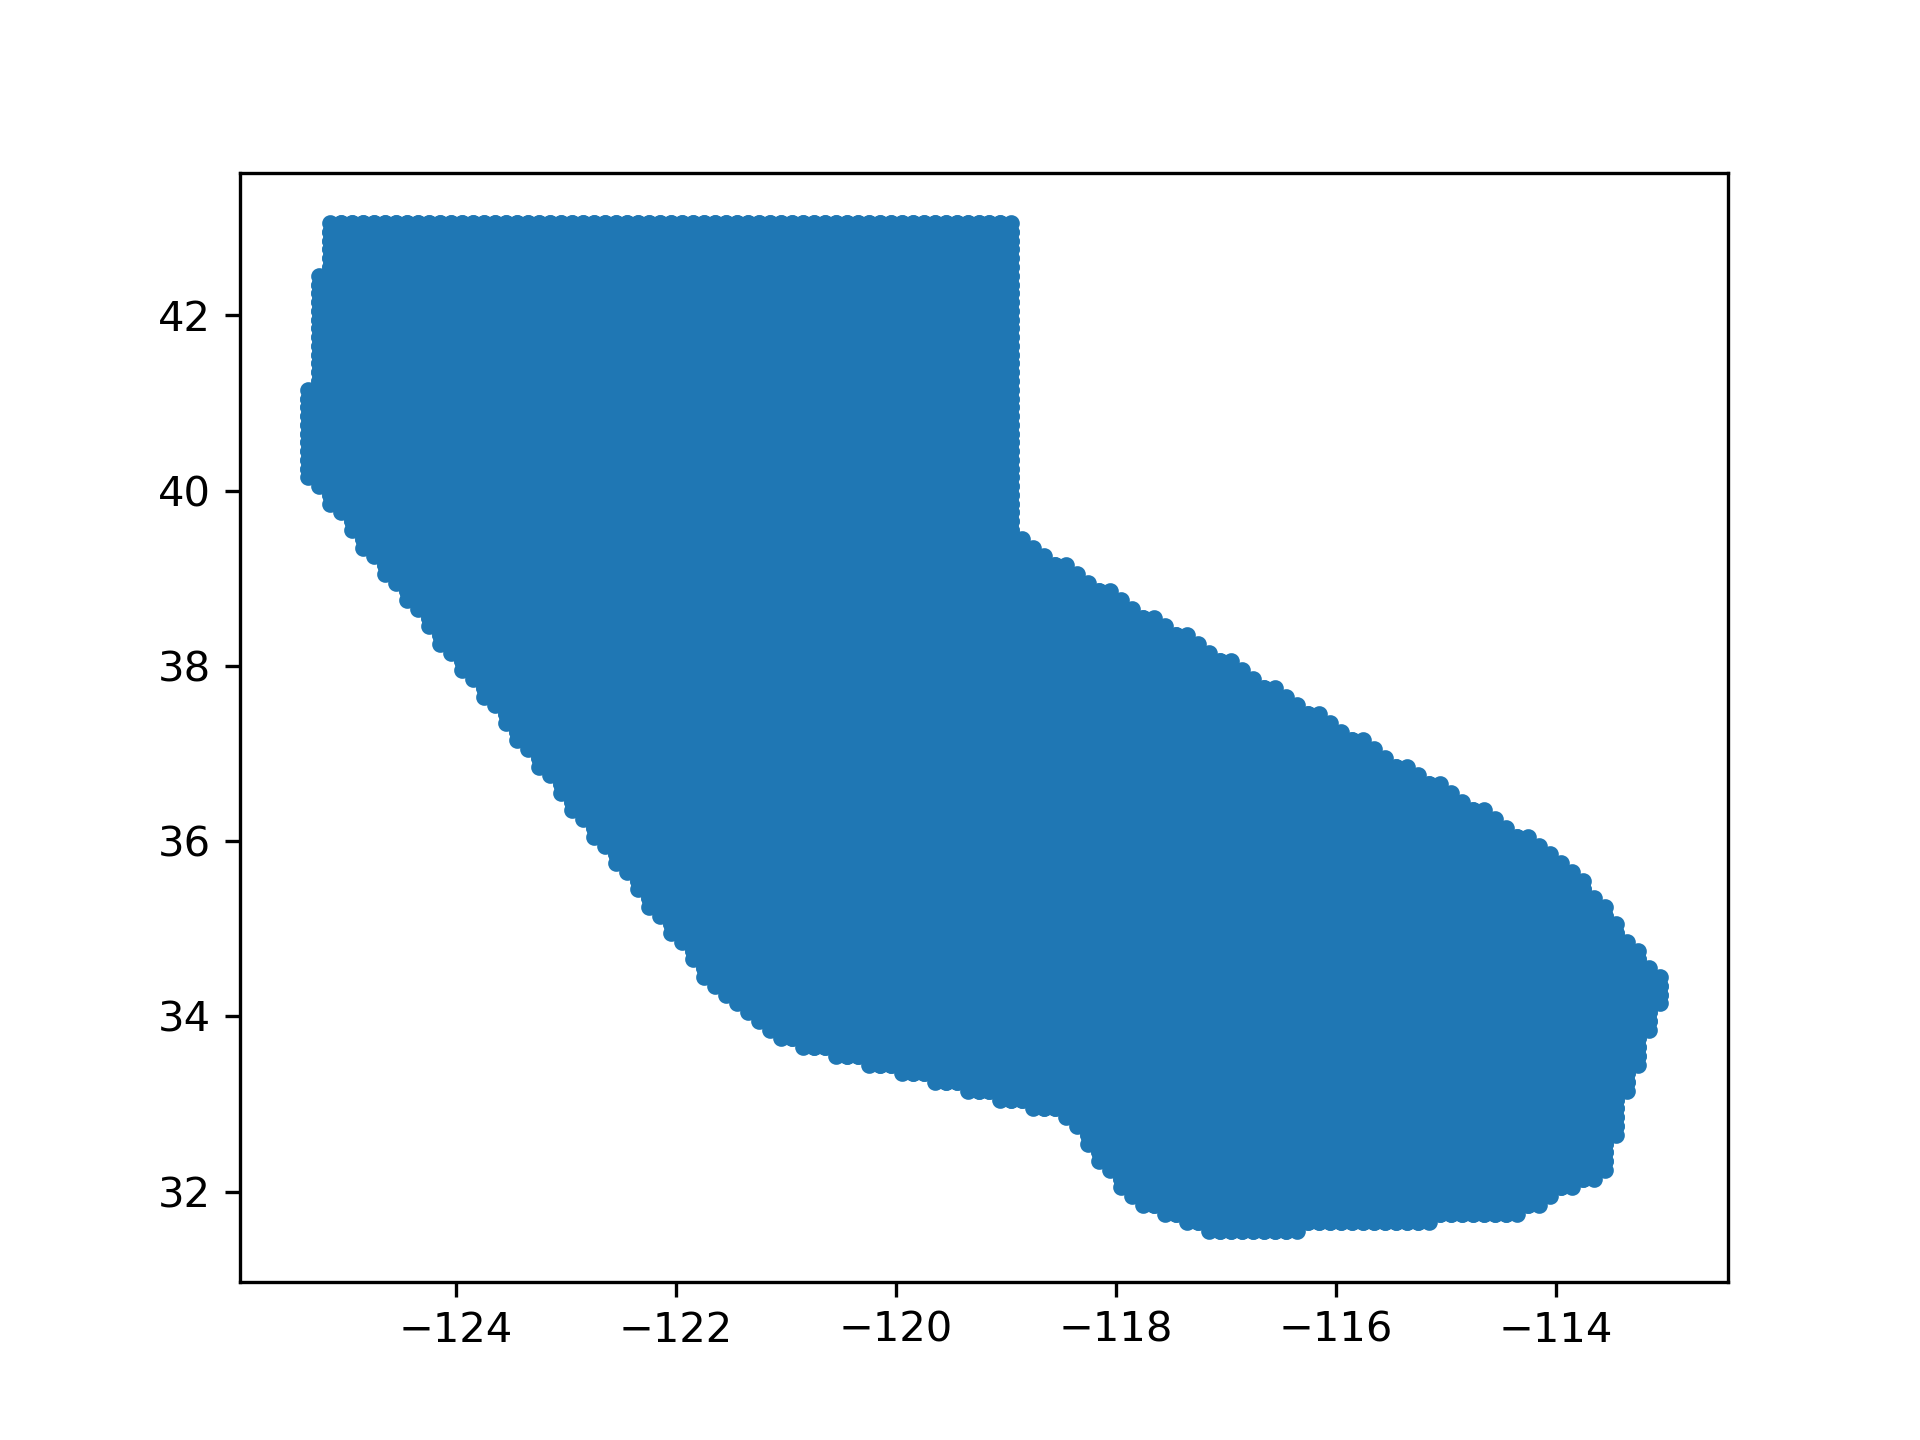

In [34]:
t0 = time.time()
split_catalogs = bin_catalog_spatial(comcat, polygons)
t1 = time.time()
print('Binned 1 catalog in {} seconds.'.format(t1-t0))

fig = plt.figure()
ax = fig.gca()
plot_polygons = np.array([catalog.region.bbox for catalog in split_catalogs])
f,s,t = plot_polygons.shape
plot_polygons = plot_polygons.reshape([f*s,t])
ax.plot(plot_polygons[:,0], plot_polygons[:,1], '.')

In [26]:
# read in ucerf3 simulations
project_root = '/Users/wsavran/Projects/CSEP2/u3etas_simulations/landers_experiment'
filename = os.path.join(project_root, '10-23-2018_landers-pt1/results_complete.bin')
filename_nofaults = os.path.join(project_root, '10-31-2018_landers-nofaults-pt1/results_complete.bin')

u3catalogs = csep.load_stochastic_event_set(filename=filename, format='native', type='ucerf3', name='UCERF3-ETAS')
ses = []
for catalog in u3catalogs:
    ses.append(catalog.filter("magnitude > 3.95"))

In [18]:
# apply filtering routine to ses
split_ses = []
for i, catalog in enumerate(ses):
    print(i)
    split_ses.append(bin_catalog_spatial(catalog, polygons))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


KeyboardInterrupt: 